In [1]:
import matplotlib.pyplot as plt
from __future__ import annotations
from BikeData import BikeData
from typing import Tuple, List
from scipy import stats
import numpy as np
plt.rcParams["text.usetex"]=True
plt.rcParams["font.family"]="serif"
plt.rcParams["font.size"]=16


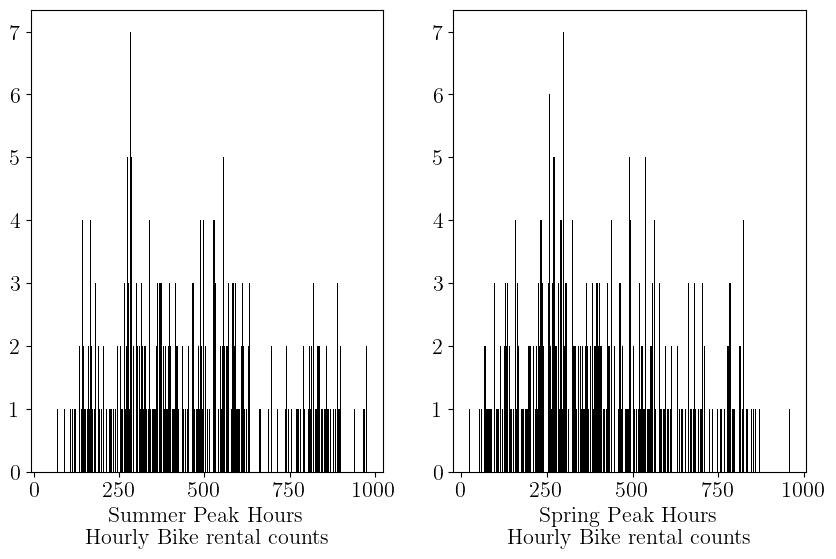

In [2]:
"""
Load the hourly data. Remove the non working days. Select only the peak
hours.
"""
hourly = BikeData("hour.csv")
summer_peak = hourly.subset(
    eq={"season": 3, "holiday": 0, "workingday": 1}, leq={"hr": 19}, geq={"hr": 15}
)
spring_peak = hourly.subset(
    eq={"season": 2, "holiday": 0, "workingday": 1}, leq={"hr": 19}, geq={"hr": 15}
)
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].hist(summer_peak.data["cnt"], bins=summer_peak.data.shape[0], color="black")
ax[1].hist(spring_peak.data["cnt"], bins=spring_peak.data.shape[0], color="black")
ax[1].set_xlabel("Spring Peak Hours\n Hourly Bike rental counts")
ax[0].set_xlabel("Summer Peak Hours\n Hourly Bike rental counts");
"""
The Histograms are misleading. The values can take such a wide range of
values that even if the distribution is normal, some of the points take
the same values. Thus a qq plot is more appropreate.
""";

In [3]:
def probplot_to_plot(os_tup: Tuple[List], slope_tup: Tuple[float]):
    """
    Takes the output of stats.probplot, and returns convinent output for
    matplotlib plotting.
    """
    osm, osr = os_tup
    slope, intercept, r = slope_tup
    m_min, m_max = np.min(osm), np.max(osm)
    return (osm, osr), (
        [m_min, m_max],
        [slope * m_min + intercept, slope * m_max + intercept],
    )



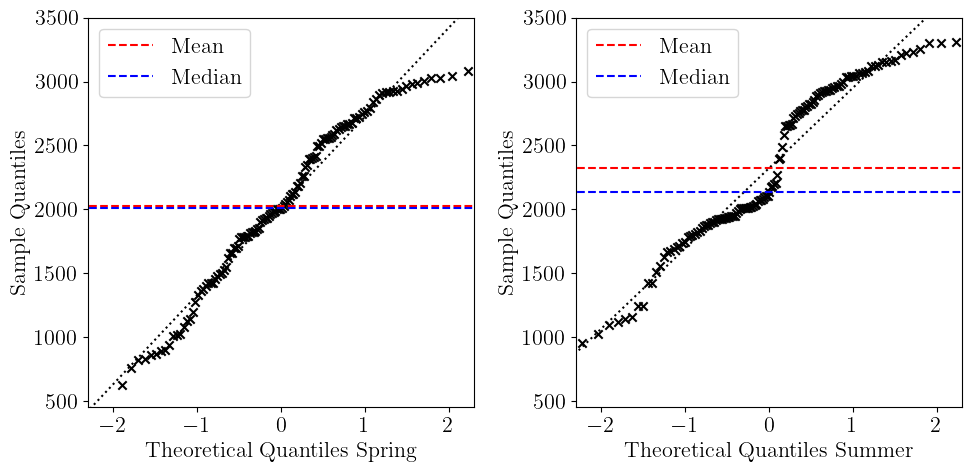

In [18]:
"""
Perform the aggregation.
"""
day_sum_sp = spring_peak.column_reduce("dteday", "cnt", np.sum)
day_sum_su = summer_peak.column_reduce("dteday", "cnt", np.sum)
sp_sort = np.array([i for i in day_sum_sp.values()])
su_sort = np.array([i for i in day_sum_su.values()])
su_mean, sp_mean = np.mean(su_sort), np.mean(sp_sort)
su_median, sp_median = np.median(su_sort), np.median(sp_sort)
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Fig 0
sp_tup_1, sp_tup_2 = stats.probplot(sp_sort, dist="norm")
(m, r), (l_m, l_r) = probplot_to_plot(sp_tup_1, sp_tup_2)
ax[0].plot(l_m, l_r, c="black", linestyle=":")
ax[0].scatter(m, r, marker="x", c="black")
ax[0].plot([m[0], m[-1]],[sp_mean, sp_mean], linestyle="--", c="red", label="Mean")
ax[0].plot([m[0], m[-1]],[sp_median, sp_median], linestyle="--", c="blue", label="Median")
ax[0].set_xlabel("Theoretical Quantiles Spring")
ax[0].set_ylabel("Sample Quantiles")
ax[0].legend()
# Fig 1
su_tup_1, su_tup_2 = stats.probplot(su_sort, dist="norm")
(m, r), (l_m, l_r) = probplot_to_plot(su_tup_1, su_tup_2)
ax[1].plot(l_m, l_r, c="black", linestyle=":")
ax[1].plot([m[0], m[-1]],[su_mean, su_mean], linestyle="--", c="red", label="Mean")
ax[1].plot([m[0], m[-1]],[su_median, su_median], linestyle="--", c="blue", label="Median")
ax[1].scatter(m, r, marker="x", c="black")
ax[1].set_xlabel("Theoretical Quantiles Summer")
ax[1].set_ylabel("Sample Quantiles")
for axis in ax:
    axis.set_ylim(450,3500)
    axis.set_xlim(-2.3,2.3)
ax[1].legend();
fig.tight_layout()
plt.savefig("/home/sean/Documents/Work/stat_0028_group_09/qqplot.png", dpi=300)


In [14]:
"""
Implementing Normality Test.
"""
# Shapiro Wilks
spring_stat, spring_pval = stats.shapiro(sp_sort)
print(f"Spring Shapiro Wilks Statistic: {spring_stat:.3}")
print(f"Spring Shapiro Wilks Pvalue: {spring_pval:.3}\n")
summer_stat, summer_pval = stats.shapiro(su_sort)
print(f"Summer Shapiro Wilks Statistic: {summer_stat:.3}")
print(f"Summer Shapiro Wilks Pvalue: {summer_pval:.3}\n")
# Anderson Darlin
spring_stat, spring_cv, spring_sig= stats.anderson(sp_sort)
print(f"Spring Anderson Statistic: {spring_stat:.3}")
print(f"Critical Values: {spring_cv}")
print(f"Significance Levels: {spring_sig}\n")
summer_stat, summer_cv, summer_sig = stats.anderson(su_sort)
print(f"Summer Anderson Statistic: {summer_stat:.3}")
print(f"Critical Values: {summer_cv}")
print(f"Significance Levels: {summer_sig}")


Spring Shapiro Wilks Statistic: 0.972
Spring Shapiro Wilks Pvalue: 0.00851

Summer Shapiro Wilks Statistic: 0.943
Summer Shapiro Wilks Pvalue: 2.94e-05

Spring Anderson Statistic: 1.0
Critical Values: [0.559 0.637 0.764 0.892 1.06 ]
Significance Levels: [15.  10.   5.   2.5  1. ]

Summer Anderson Statistic: 3.08
Critical Values: [0.56  0.637 0.765 0.892 1.061]
Significance Levels: [15.  10.   5.   2.5  1. ]


In [21]:
"""
Performing two sample tests.
"""
print(f" Spring median: {sp_median} \n Summer median: {su_median}\n")

stat, p , med, tbl = stats.median_test(sp_sort, su_sort)
print(f" Moody's Median Test P value: {p:.4}\n Statistic {stat:.4}")

stat, p = stats.mannwhitneyu(sp_sort, su_sort)
print(f" Spring mean: {sp_mean} \n Summer mean: {su_mean}\n")
print(f" U Mean Test P value: {p:.4} \n Statistic {stat:.4}")


 Spring median: 2007.0 
 Summer median: 2135.0

 Moody's Median Test P value: 0.2905
 Statistic 1.118
 Spring mean: 2027.6640625 
 Summer mean: 2323.2824427480914

 U Mean Test P value: 0.0005571 
 Statistic 6.303e+03
